# Task #1: find the Master Bias!

What is the bias? The bias is a pedestal level added to the signal during the detector readout. 

Why do we need to subtract it? The bias contribution to the signal is present in all frames observed and simply sums to the true signal that we aim to measure.

How? The bias must be subtracted from all other frames observed, including the science frames. The goal of this workbook is to estimate the bias contribution combining the bias frames, i.e. observations taken with a zero exposure time. As a result we will obtain a new frame called "Master Bias" that we will subtract from the other frames.

In [1]:
# Importing all needed packages
# Standard packages for data visualization
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt   
%matplotlib notebook

# Packages for reading astronomical data stored in fits files and accessing file paths
from astropy.io import fits  # to read fits files with python
import glob  # to find path names

# Packages for importing ad-hoc modules and other
import importlib
import sys
#importlib.reload(sys.modules['data_reduction']) #uncomment when you edit the module data_reduction.py
from data_reduction import *
import datetime

For start, let's save into a list the paths of all the fits files that appear in our data directory and let's display them below.

In [2]:
# Directory of the data 
path2data = '/home/masi1109/Documents/PhD/ObsII/not2mattia'
# List of filenames 
fnames = glob.glob(path2data+'/*.fits', recursive=True) # the asterisk stands for any combination of letters  
fnames

['/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130146_b_f.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130145_b.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130213.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130148_b.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130147.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130217.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130144_b_f.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130155_b_f.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130149.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/master_flat_mean.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130145_b_f.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130147_b.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130211.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130132.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/

# Bias checks: exposure time, frame dimension and pixels statistics

Astronomical data are saved in the so-called .fits format. This stands for Flexible Image Transport System (FITS) and has been the standard in astronomy since 1981. FITS-files generally contain two parts: an image, consisting in a frame where each pixel has a value assigne; and a header that contains all metadata such as the image type, who made the observation and when, the exposure time, the frame dimension, etc.

In the cell below we access each bias file, read some basic information within the header and compute some pixel statistics. For each bias frame we print:

-> path name

-> exposure time

-> fame dimension in pixel
 
-> total number of pixels

-> mean, median, standard deviation value of pixels values

In [3]:
# Doing the necessary checks on the bias frames and printing them out

BIAS_EXP_MAX = 0.1  # exposure time of the bias frame is expected to be zero or very short

# List of filenames of the bias frames
bias_names = []
bias_frames = []
for file in fnames:
    hdul = fits.open(file)  # reading the fits file (headers and pixel values)
    
    # An HDU (Header Data Unit) is the highest level component of the FITS file structure, 
    # consisting of a header and (typically) a data array or table.
    
    if hdul[0].header['IMAGETYP'] == 'BIAS':
        bias_names.append(file)  # add to the list of bias names
        exp_t = hdul[0].header['EXPTIME']  # exposure time 
        xdim = hdul[1].header['NAXIS1']  # lenght of x axis
        ydim = hdul[1].header['NAXIS2']  # lenght of y axis
        n_pixels = xdim * ydim  # number of pixels
        
        bias_frames.append(hdul[1].data)  #add to the list of bias frames 
        
        # Computing statistics of the pixel values within a window exluding 10% on each side of both axis
        stats = ImageStats("bias_frame_statistics") # define the object where saving the statistics, name is optional
        stats.compute_imstats(hdul[1].data, int(0.1*xdim), int(0.9*xdim), int(0.1*ydim), int(0.9*ydim))
        bias_mean = stats.mean
        bias_median = stats.median
        bias_std = stats.std        
        
        print(file, " exp =", exp_t, " frame =", xdim, "x", ydim, "nPixels =", n_pixels)
        print("Image statistics: mean =", bias_mean, " median =", bias_median, " std =", bias_std)
        
        if exp_t > BIAS_EXP_MAX: print("WARNING: the exposure time of the frame above is longer than 0.1s. "
                              "Frame might have been specified as BIAS by mistake.")
            
        print("")
    hdul.close()

bias_array = np.array(bias_frames)

/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130213.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10339.58410548861  median = 10339.58410548861  std = 27.633485367954947

/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130217.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10344.950893865982  median = 10344.950893865982  std = 27.20120593711205

/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130211.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10339.899458721315  median = 10339.899458721315  std = 28.41703409599172

/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130218.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10344.230020774221  median = 10344.230020774221  std = 25.583373664146826

/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130215.fits  exp = 0.002  frame = 2148 x 2102 nPixels = 4515096
Image statistics: mean = 10342.684

How does a bias frame look like?

<IPython.core.display.Javascript object>


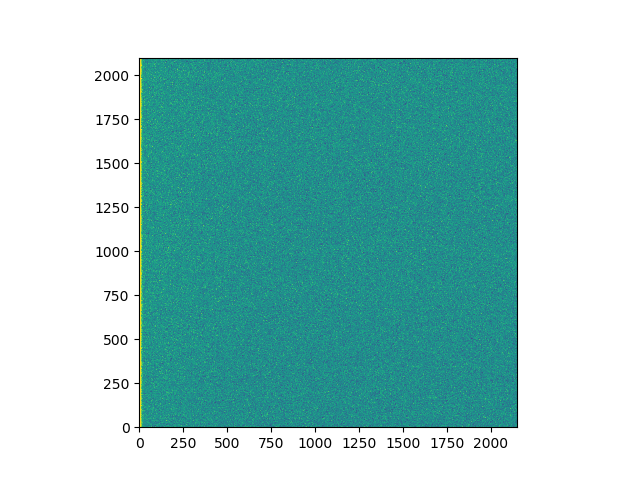

In [4]:
# Plotting one bias frame as an example
b = bias_array[0]
plt.figure()
plt.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

# Combining the bias frames into the Master Bias   

How to combine the bias frames into a single Master Bias? 

We will use two methods:

1) compute for each pixel the mean value along the stack of bias frames

2) compute for each pixel the median value along the stack of bias frames

We will then create a fits file for the Master Bias obtained with the "mean" method

<IPython.core.display.Javascript object>


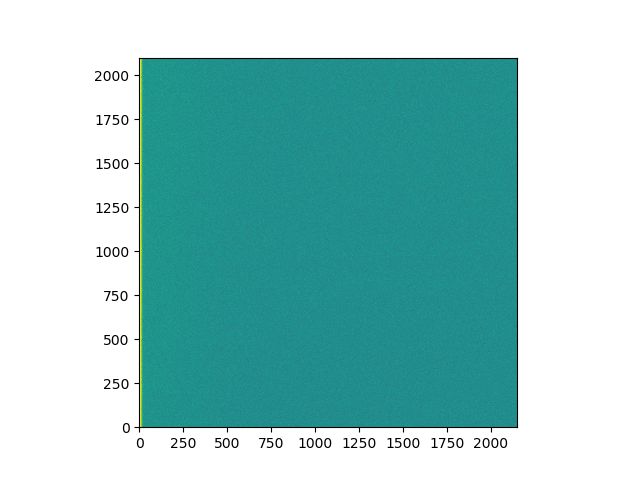

<IPython.core.display.Javascript object>


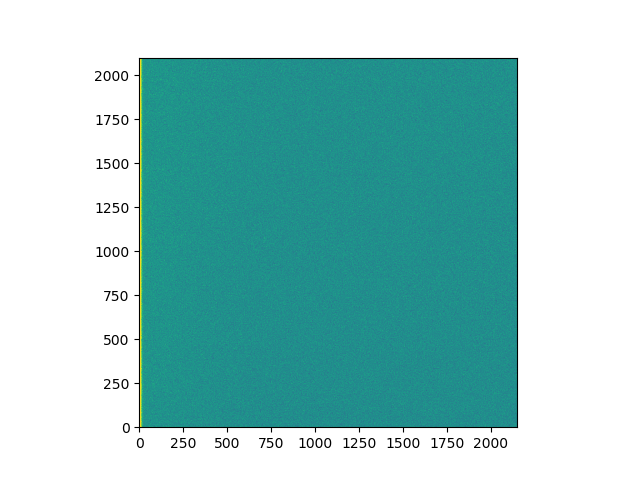

In [5]:
# Computing the master bias using a function defined in data_reduction.py module
# Two methods of combination are available: (1) mean or (2) median
master_bias1 = get_master(bias_array, method="mean", n_clip=2)
master_bias2 = get_master(bias_array, method="median", n_clip=2)

b = master_bias1
plt.figure()
plt.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

c = master_bias2
plt.figure()
plt.imshow(c, origin='lower', vmin=np.median(c)-2*np.std(c), vmax =np.median(c)+2*np.std(c))

# Creating a fits file for the master bias obtained with the "mean" method
hdu = fits.ImageHDU(master_bias1)

hdr = fits.Header()
now = datetime.datetime.now()
now_string = now.strftime("%Y-%m-%d %H:%M:%S")
hdr['COMMENT'] = "Master Bias frame (mean of bias frames) obtained on " + now_string
hdr['IMAGETYP'] = 'MASTER BIAS'
empty_primary = fits.PrimaryHDU(header=hdr)

hdul = fits.HDUList([empty_primary, hdu])
master_name = path2data + '/master_bias_mean.fits'
hdul.writeto(master_name, overwrite=True)

# Subtracting the Master Bias from all the other frames 

The Master Bias rapresents the best estimate of the bias contribution to the signal that we want to subtract (pixel-by-pixel) from all other frames that are not bias frames.

Below we do that, leaving a comment in the header of each newly created fits file. The original files are kept unchanged. The new files are named with the suffix "_b". 

We print below the name of the new bias-subtracted files and their image type.

In [6]:
# Subtracting the master bias (mean) from all other frames that are not bias frames

hdul_master = fits.open(path2data+'/master_bias_mean.fits')

for file in fnames:
    hdul = fits.open(file)
    
    if 'BIAS_SUB' in hdul[0].header:  # if bias has been subtracted already we skip to the next frame
        continue 
    
    imtyp = hdul[0].header['IMAGETYP']
    if imtyp == 'FLAT,LAMP' or imtyp == 'WAVE,LAMP' or imtyp == 'OBJECT':
        
        hdul[1].data = hdul[1].data - master_bias1
        print("Master Bias subtracted from frame", file, "of image type:\n", hdul[0].header['IMAGETYP'])
        
        comment = "Master Bias subtracted on "
        now = datetime.datetime.now()
        comment += now.strftime("%Y-%m-%d %H:%M:%S")
        comment += " using master bias file " + master_name
        hdul[0].header['HISTORY'] = comment
        hdul[0].header['COMMENT'] = comment
        hdul[0].header['BIAS_SUB'] = 'Yes'
        
        new_file_name = file.replace(".fits", "_b.fits")
        hdul.writeto(new_file_name, overwrite=True)
        print("New fits file created for the bias-subtracted frame:", new_file_name, "\n")
    
    hdul.close()
    
hdul_master.close()

Master Bias subtracted from frame /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130147.fits of image type:
 FLAT,LAMP
New fits file created for the bias-subtracted frame: /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130147_b.fits 

Master Bias subtracted from frame /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130149.fits of image type:
 FLAT,LAMP
New fits file created for the bias-subtracted frame: /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130149_b.fits 

Master Bias subtracted from frame /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130132.fits of image type:
 OBJECT
New fits file created for the bias-subtracted frame: /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130132_b.fits 

Master Bias subtracted from frame /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130155.fits of image type:
 OBJECT
New fits file created for the bias-subtracted frame: /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130155_b.fits 

Master Bias subtracted from frame /home/ma